# Terrain Classification - Combined User Data
### Created by Keenan McConkey 2019.08.01

In [49]:
from __future__ import absolute_import, division, print_function

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pymrmr
import sklearn

0.21.2


## Part 1 - Importing Preprocessed Data

### Part (a) - Functions for Data Import

In [71]:
# All the terrains, placements, vectors, power-assistance, users in the study
terrains = ['Concrete', 'Carpet', 'Linoleum', 'Asphalt', 'Sidewalk', 'Grass', 'Gravel']
powers = ['Manual'] # TODO: Fix power PSD data and add back in
placements_manual = ['Middle', 'Left', 'Right', 'Synthesis']
placements_power = ['Middle']
vectors = ['Features', 'FFTs', 'PSDLogs']
users = ['Keenan', 'Kevin', 'Mahsa', 'Jamie']
axes = ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro']

In [3]:
'''Get the integer terrain value of a given label'''
def get_terrain_num(_label):
    for i, terrain in enumerate(terrains):
        if terrain in _label:
            return i
        
    raise Exception('Unknown terrain')

'''Get the name associated with a terrain integer'''
def get_terrain_name(terrain_num):
    return terrains[terrain_num]
    return terrains[terrain_num]

'''Get the placement location name for given label'''
def get_placement(_label):
    for placement in placements:
        if placement in _label:
            return placement
    
    raise Exception('Unknown placement')

'''Get the transform used for given label'''
def get_transform(_label):
    for transform in transforms:
        if transform in _label:
            return transform
    
    raise Exception('Unknown transform')

### Part (b) - Import Processed Data from Each User

In [4]:
'''Combine data from labelled datasets into a single dataframe'''
def combine_datasets(datasets):
    return pd.concat(list(datasets.values()), ignore_index=True, sort=False)

In [72]:
path = 'processed_data/new_setup/' 

# Nested dictionary of processed data:
# - Power assistance type
# -- Placement
# --- Feature Vector
# ---- User
power_dict = {}

# Create each nesting of the dictionary
for power in powers:
    placement_dict = {}
    
    # Power datasets only have middle placement (for now)
    if power == 'Power':
        placements = placements_power.copy()
    else:
        placements = placements_manual.copy()
    
    for placement in placements:
        vector_dict = {}

        for vector in vectors:
            user_dict = {}

            for user in users:
                # File name based on above parameters
                filename = power.lower() + '/' + placement + '_' + vector + '_Filt_' + user 
                if power == 'Power':
                    filename += '_Power'
                filename += '.csv'
                
                # Read data and update current user dictionary
                data = pd.read_csv(path + filename)
                user_dict.update({user: data})

            # Combine users to form a new entry of user dictionary, save to .csv
            # NaNs arise when you combine Synthesis feature vectors
            combined_data = combine_datasets(user_dict).dropna(axis='columns')
            user_dict.update({'All': combined_data})

            vector_dict.update({vector: user_dict})
        
        # Create a dictionary of the combined feature vector for each user
        combined_vector_user_dict = {}
        
        for user in user_dict.keys():
            # Get all vectors for current user and pop label column
            user_all_vectors = []
            
            for vector in vector_dict.values():
                user_vector = vector[user].copy()
                labels = user_vector.pop('Label') # All label columns should be the same
                user_all_vectors.append(user_vector)
            
            # Combine vectors and add back label column
            combined_vector = pd.concat(user_all_vectors, axis='columns')
            combined_vector.insert(loc=0, column='Label', value=labels)
            combined_vector_user_dict.update({user: combined_vector})
        
        # Add the combined feature vector to the vector dictionary
        vector_dict.update({'Combined': combined_vector_user_dict})
        
        placement_dict.update({placement: vector_dict})
    
    power_dict.update({power: placement_dict})

In [73]:
# Update vectors to reflect new combined vector
vectors.append('Combined')

In [79]:
# Check some data
power_dict['Manual']['Middle']['Combined']['All'].tail()

,Label,Mean X Accel Middle,Std Dev X Accel Middle,L2 Norm X Accel Middle,Autocorrelation X Accel Middle,Max X Accel Middle,Min X Accel Middle,Root Mean Squared X Accel Middle,Zero Crossing Rate X Accel Middle,Skew X Accel Middle,...,PSD 1.0 Hz X Gyro Middle,PSD 1.0 Hz Z Accel Middle,PSD 1.0 Hz Y Accel Middle,PSD 1.0 Hz X Accel Middle,PSD 0.0 Hz Z Gyro Middle,PSD 0.0 Hz Y Gyro Middle,PSD 0.0 Hz X Gyro Middle,PSD 0.0 Hz Z Accel Middle,PSD 0.0 Hz Y Accel Middle,PSD 0.0 Hz X Accel Middle
8012,5,-0.048488,-0.146781,-0.224684,-0.293490,-0.369834,0.803903,-0.224684,0.410072,-0.295411,...,-3.199153,-2.119317,-1.360919,-1.726940,-1.125372,-2.414256,-3.104088,-1.992795,-0.906233,-0.163503
8013,5,-0.838211,-0.549810,-0.679571,-0.697007,-0.727631,0.649344,-0.679571,-1.279923,0.891646,...,-2.854475,-1.476822,-1.801745,-0.448959,-1.699782,-2.961492,-2.498364,-1.379586,-1.488251,0.043019
8014,5,-0.058510,-1.523523,-1.527153,-1.358674,-0.612425,0.753509,-1.527153,1.255070,0.353343,...,-2.651156,-2.436379,-1.318068,-1.271694,-1.236619,-2.188757,-2.502940,-1.908180,-1.126076,-0.427966
8015,5,0.068267,1.145593,1.019167,0.982532,2.396203,-0.863990,1.019167,-0.434925,1.624021,...,-3.348061,-2.113860,-2.132868,-0.466117,-1.621375,-2.014946,-3.373160,-2.914507,-1.887899,0.042225
8016,5,-0.180351,-1.198178,-1.241871,-1.149074,-0.756011,1.430402,-1.241871,-0.857424,-0.327254,...,-3.855377,-2.770625,-2.242923,-1.473848,-1.418449,-2.783864,-2.749813,-2.456584,-0.994285,-0.041851


## Part 2 -  mRMR (minimum Redunancy Maximum Relevance)

mRMR tries to find which features have the highest information shared with classified state and lowest information shared with other features.

### Part (a) - Middle Frame Placement

#### Part (i) - Manual Wheelchair

In [8]:
pymrmr.mRMR(data=power_dict['Manual']['Middle']['Features']['All'], method='MID', nfeats=5)

['Variance Frequency X Accel Middle',
 'Excess Kurtosis Z Accel Middle',
 'Variance Frequency Y Gyro Middle',
 'Zero Crossing Rate Z Gyro Middle',
 'Variance Frequency X Gyro Middle']

In [9]:
pymrmr.mRMR(data=power_dict['Manual']['Middle']['FFTs']['All'], method='MID', nfeats=5)

['FFT 0.0 Hz Y Accel Middle',
 'FFT 32.0 Hz Z Accel Middle',
 'FFT 31.0 Hz Z Accel Middle',
 'FFT 29.0 Hz Z Accel Middle',
 'FFT 0.0 Hz Z Gyro Middle']

In [10]:
pymrmr.mRMR(data=power_dict['Manual']['Middle']['PSDLogs']['All'], method='MID', nfeats=5)

['PSD 55.0 Hz Y Accel Middle',
 'PSD 0.0 Hz Y Gyro Middle',
 'PSD 37.0 Hz Y Gyro Middle',
 'PSD 3.0 Hz Y Gyro Middle',
 'PSD 56.0 Hz Y Accel Middle']

In [11]:
pymrmr.mRMR(data=power_dict['Manual']['Middle']['Combined']['All'], method='MID', nfeats=5)

['PSD 55.0 Hz Y Accel Middle',
 'PSD 0.0 Hz Y Gyro Middle',
 'PSD 37.0 Hz Y Gyro Middle',
 'PSD 3.0 Hz Y Gyro Middle',
 'PSD 56.0 Hz Y Accel Middle']

#### Part (i) - Power Assist Wheelchair

In [12]:
#pymrmr.mRMR(data=power_dict['Power']['Middle']['Features']['All'], method='MID', nfeats=5)

In [13]:
#pymrmr.mRMR(data=power_dict['Power']['Middle']['FFTs']['All'], method='MID', nfeats=5)

In [14]:
#pymrmr.mRMR(data=power_dict['Power']['Middle']['PSDLogs']['All'], method='MID', nfeats=5)

In [15]:
#pymrmr.mRMR(data=power_dict['Power']['Middle']['Combined']['All'], method='MID', nfeats=5)

### Part (b) - Left Wheel Placement

In [16]:
pymrmr.mRMR(data=power_dict['Manual']['Left']['Features']['All'], method='MID', nfeats=5)

['Min Y Accel Left',
 'Zero Crossing Rate Y Gyro Left',
 'Min X Accel Left',
 'Max X Accel Left',
 'Max Y Accel Left']

In [17]:
pymrmr.mRMR(data=power_dict['Manual']['Left']['FFTs']['All'], method='MID', nfeats=5)

['FFT 0.0 Hz Z Gyro Left',
 'FFT 33.0 Hz X Accel Left',
 'FFT 4.0 Hz Y Accel Left',
 'FFT 52.0 Hz Z Accel Left',
 'FFT 4.0 Hz X Accel Left']

In [18]:
pymrmr.mRMR(data=power_dict['Manual']['Left']['PSDLogs']['All'], method='MID', nfeats=5)

['PSD 63.0 Hz Z Accel Left',
 'PSD 16.0 Hz Z Accel Left',
 'PSD 36.0 Hz Z Accel Left',
 'PSD 47.0 Hz X Accel Left',
 'PSD 53.0 Hz Y Accel Left']

In [19]:
pymrmr.mRMR(data=power_dict['Manual']['Left']['Combined']['All'], method='MID', nfeats=5)

['PSD 63.0 Hz Z Accel Left',
 'PSD 16.0 Hz Z Accel Left',
 'PSD 36.0 Hz Z Accel Left',
 'FFT 0.0 Hz Z Gyro Left',
 'PSD 27.0 Hz Z Accel Left']

### Part (c) - Right Wheel Placement

In [20]:
pymrmr.mRMR(data=power_dict['Manual']['Right']['Features']['All'], method='MID', nfeats=5)

['Min X Accel Right',
 'Min Y Accel Right',
 'Variance Frequency Z Accel Right',
 'Max X Accel Right',
 'Max Y Accel Right']

In [21]:
pymrmr.mRMR(data=power_dict['Manual']['Right']['FFTs']['All'], method='MID', nfeats=5)

['FFT 0.0 Hz Z Gyro Right',
 'FFT 53.0 Hz Z Accel Right',
 'FFT 52.0 Hz Z Accel Right',
 'FFT 55.0 Hz Z Accel Right',
 'FFT 54.0 Hz Z Accel Right']

In [22]:
pymrmr.mRMR(data=power_dict['Manual']['Right']['PSDLogs']['All'], method='MID', nfeats=5)

['PSD 62.0 Hz Z Accel Right',
 'PSD 16.0 Hz Z Accel Right',
 'PSD 56.0 Hz Z Accel Right',
 'PSD 46.0 Hz X Accel Right',
 'PSD 20.0 Hz Z Accel Right']

In [23]:
pymrmr.mRMR(data=power_dict['Manual']['Right']['Combined']['All'], method='MID', nfeats=5)

['PSD 62.0 Hz Z Accel Right',
 'PSD 16.0 Hz Z Accel Right',
 'PSD 56.0 Hz Z Accel Right',
 'FFT 0.0 Hz Z Gyro Right',
 'PSD 63.0 Hz Z Accel Right']

### Part (d) - Synthesis "Placement"

In [24]:
pymrmr.mRMR(data=power_dict['Manual']['Synthesis']['Features']['All'], method='MID', nfeats=5)

['Min Left Y Accel Synthesis',
 'Min Right X Accel Synthesis',
 'Zero Crossing Rate Left Y Gyro Synthesis',
 'Min Left X Accel Synthesis',
 'Min Right Y Accel Synthesis']

In [25]:
pymrmr.mRMR(data=power_dict['Manual']['Synthesis']['FFTs']['All'], method='MID', nfeats=5)

['FFT 0.0 Hz Right Z Gyro Synthesis',
 'FFT 0.0 Hz Left XY Accel Synthesis',
 'FFT 0.0 Hz Calc Z Gyro Synthesis',
 'FFT 0.0 Hz Right XY Accel Synthesis',
 'FFT 0.0 Hz Left Z Gyro Synthesis']

In [26]:
pymrmr.mRMR(data=power_dict['Manual']['Synthesis']['PSDLogs']['All'], method='MID', nfeats=5)

['PSD 39.0 Hz Left XY Accel Synthesis',
 'PSD 15.0 Hz Right Z Accel Synthesis',
 'PSD 63.0 Hz Right Z Accel Synthesis',
 'PSD 51.0 Hz Left XY Accel Synthesis',
 'PSD 13.0 Hz Left XY Accel Synthesis']

In [27]:
pymrmr.mRMR(data=power_dict['Manual']['Synthesis']['Combined']['All'], method='MID', nfeats=5)

['PSD 39.0 Hz Left XY Accel Synthesis',
 'PSD 15.0 Hz Right Z Accel Synthesis',
 'PSD 63.0 Hz Right Z Accel Synthesis',
 'PSD 51.0 Hz Left XY Accel Synthesis',
 'PSD 13.0 Hz Left XY Accel Synthesis']

### Part (e) - Nested Dictionary of Top Features

In [83]:
# Create dictionary of top mRMR features to speed up calculations, up to to 20
'''
power_dict_features = {}

for power in powers:
    placement_dict_features = {}
    
    for placement in placements:
        vector_dict_features = {}
        
        for vector in vectors:
            user_dict_features = {}

            # Only calculate for all users for now
            for user in ['All']:
                top_features = pymrmr.mRMR(data=power_dict[power][placement][vector][user],
                                           method='MID', nfeats=20)
                user_dict_features.update({user: top_features})

            vector_dict_features.update({vector: user_dict_features})
            
        placement_dict_features.update({placement: vector_dict_features})
    
    power_dict_features.update({power: placement_dict_features})\
'''
print('Nothing to see here')

Nothing to see here


In [42]:
# Pickle the dictionary
import pickle

mRMR_dict_filename = '/home/caris/Wheelchair-Terrain-Classification/dicts/mRMR_Dictionary'
outfile = open(mRMR_dict_filename, 'wb')
pickle.dump(power_dict_features, outfile)
outfile.close()

In [89]:
# Unpickle the dictionary
infile = open(mRMR_dict_filename, 'rb')
power_dict_features = pickle.load(infile)
infile.close()

## Part 3 - PCA (Principal Component Analysis)

In [97]:
from sklearn.decomposition import PCA

def get_pca_df(combined_data, n_components=2):
    # Setup PCA parameters
    pca = PCA(n_components=n_components)
    
    # Copy data to avoid modification
    data = combined_data.copy()
    
    # Extract terrain labels
    labels = data.pop('Label')
    
    # Get specified number of principal components and convert to dataframe
    pc = pca.fit_transform(data)
    pc_df = pd.DataFrame(data=pc, columns=['PC {}'.format(i + 1) for i in range(n_components)])
    
    #print('Explained Variance of Each PC: {}'.format(pca.explained_variance_ratio_))
    #print('Total Explained Variance: {}'.format(np.sum(pca.explained_variance_ratio_)))
    
    return pd.concat([labels, pc_df], axis='columns')

In [31]:
get_pca_df(power_dict['Manual']['Synthesis']['Combined']['All']).tail()

Explained Variance of Each PC: [0.25027049 0.07382345]
Total Explained Variance: 0.3240939382974105


,Label,PC 1,PC 2
9006,0,-2.984788,17.079065
9007,0,0.807217,6.008955
9008,0,-2.972026,-4.055598
9009,0,12.526190,-3.162052
9010,0,-0.869684,-19.993115


In [51]:
get_pca_df(power_dict['Manual']['Synthesis']['Combined']['All'], n_components=5).tail()

Explained Variance of Each PC: [0.25027049 0.07382345 0.06217423 0.04354003 0.03294275]
Total Explained Variance: 0.4627509458480647


,Label,PC 1,PC 2,PC 3,PC 4,PC 5
9006,0,-2.984788,17.079086,-10.302226,1.149081,-8.099625
9007,0,0.807217,6.008963,-11.757077,8.838593,1.306186
9008,0,-2.972026,-4.055609,-5.350840,8.457282,11.262321
9009,0,12.526190,-3.162050,5.366936,-6.312540,-7.426558
9010,0,-0.869684,-19.993080,11.582388,-2.862551,-4.167761


In [33]:
def visualize_2d_pca(pca_2d_df, figsize=(8, 8)):
    # Plot parameters
    plt.clf()
    plt.figure(figsize=figsize)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
    # Scatter plot of each terrain
    for terrain in terrains:
        terrain_indices = pca_2d_df['Label'] == get_terrain_num(terrain)
        plt.scatter(pca_2d_df.loc[terrain_indices, 'PC 1'], pca_2d_df.loc[terrain_indices, 'PC 2'])
    
    plt.legend(terrains)
    plt.show()

Explained Variance of Each PC: [0.14097549 0.10129629]
Total Explained Variance: 0.24227178794259607


<Figure size 432x288 with 0 Axes>

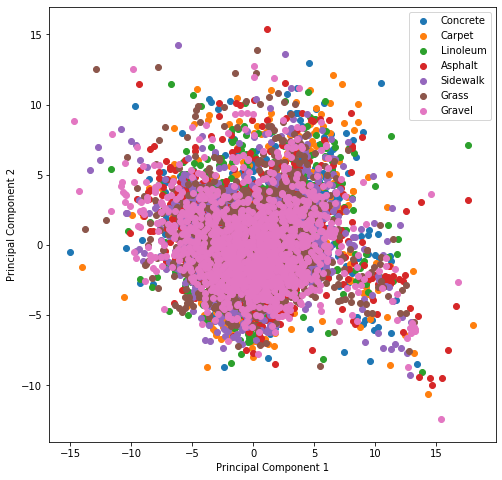

In [34]:
visualize_2d_pca(get_pca_df(power_dict['Manual']['Right']['Features']['All']))

## Part 4 - Comparing Classifier Accuracy

In [35]:
from sklearn.model_selection import KFold

'''Run train test k-fold times
   Returns an tuple of arrays, where arrays elements are actual/predicted labels for each k-fold test'''
def train_test_k_fold(combined_data, n_splits, model):
    # Shuffle ensures we get a mix of terrains
    kf = KFold(n_splits=n_splits, shuffle=True)

    # Copy data to avoid modification
    data = combined_data.copy()
    
    # Extract terrain labels
    labels = data.pop('Label')

    # Array of predicted labels for each k fold
    test_k_fold = []
    predict_k_fold = []

    # Split into n splits
    for train_index, test_index in kf.split(data):
        train, test = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        
        # Actual labels
        test_k_fold.append(test_labels)
        
        # Train and test model
        model.fit(train, train_labels)
        predict_k_fold.append(model.predict(test))

    return (test_k_fold, predict_k_fold)

In [36]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Dictionary of classifiers
classifiers = {'Naive Bayes': GaussianNB(),
               'k Nearest': KNeighborsClassifier(),
               'Decision Tree': DecisionTreeClassifier(), 
               'Random Forest': RandomForestClassifier(n_estimators=100),
               'AdaBoost': AdaBoostClassifier(),
               'Support Vector Machine': SVC(gamma='scale')}

In [112]:
def create_accuracy_table(n_splits, power_type='Manual', user_name='All', separate_axes=False,
                          feat_selection='None', n_feats=None):
    
    # Power type affects which placements are available
    if power_type == 'Manual':
        placements = placements_manual
    else:
        placements = placements_power
    
    # Dataframe table of accuracies for each classifier for each placement
    if separate_axes:
        vector_indices = [p + ' ' + v + ' ' + a for p in placements for v in vectors for a in axes]
    else:
        vector_indices = [p + ' ' + v for p in placements for v in vectors]
    
    # Vector column contains each vector for each placement and axes
    accuracy_table = pd.DataFrame({'Vector': vector_indices})

    # Calculate accuracy for each placement for each feature vector and classifier
    for classifier_name, classifier in classifiers.items():
        model = classifier

        # Row dictionary for given model
        rows = {}

        # Add current classifier to row dictionary
        for placement in placements:
            for vector in vectors:
                # Extract data for above parameters
                data = power_dict[power_type][placement][vector][user_name].copy()
                
                # Iterate through axes if we want them separate, else just put in empty string
                if separate_axes:
                    itr_axes = axes
                else:
                    itr_axes = ['All']
                
                for axis in itr_axes:
                    index_name = placement + ' ' + vector
                    data_temp = data
                    
                    # If separate axes, get data with only columns matching current axes
                    if separate_axes:
                        index_name += ' ' + axis
                        matching_columns = [column for column in data.columns if axis in column]
                        matching_columns.insert(0, 'Label')
                        data_temp = data_temp[matching_columns]
                    
                    # Use only the top features using mRMR feature selection
                    if feat_selection == 'mRMR':
                        top_feats = power_dict_features[power_type][placement][vector][user_name].copy()
                        top_feats.insert(0, 'Label')
                        data_temp = data_temp[top_feats[:n_feats+1]]

                    # Run PCA on the data
                    elif feat_selection == 'PCA':
                        data_temp = get_pca_df(data_temp, n_components=n_feats)

                    # Extract predicted and actual labels for requested user
                    actual, predict = train_test_k_fold(data_temp, n_splits, model)

                    # Take mean accuracy of k fold testing
                    accuracies = []
                    for i in range(len(predict)):
                        accuracies.append(accuracy_score(actual[i], predict[i]))
                    
                    rows.update({index_name: np.mean(accuracies)})

        # Update accuracy table with classifier column by mapping row names to indices
        accuracy_table[classifier_name] = accuracy_table['Vector'].map(rows)
    
    return accuracy_table

### Part (a) - Combined Axes Accuracy Table
#### Part (i) - No Feature Selection

In [ ]:
# Create accuracy table for 5 k-fold splits without any feature selection
accuracy_table = create_accuracy_table(n_splits=5, power_type='Manual', user_name='All')

In [64]:
accuracy_table

,Vector,Naive Bayes,k Nearest,Decision Tree,Random Forest,AdaBoost,Support Vector Machine
0,Middle Features,0.126981,0.492951,0.663714,0.725957,0.447051,0.663462
1,Middle FFTs,0.517152,0.643634,0.592493,0.756017,0.547337,0.748909
2,Middle PSDLogs,0.555320,0.694525,0.555943,0.727083,0.531365,0.775228
3,Middle Combined,0.528129,0.824249,0.675190,0.826247,0.583511,0.811402
4,Left Features,0.116062,0.391825,0.864594,0.853771,0.525158,0.530570
5,Left FFTs,0.461831,0.413126,0.480138,0.651353,0.503051,0.597927
6,Left PSDLogs,0.460564,0.477260,0.454116,0.632585,0.495912,0.670466
7,Left Combined,0.471157,0.570178,0.751756,0.773172,0.531836,0.739666
8,Right Features,0.113937,0.388673,0.906718,0.885397,0.599556,0.537479
9,Right FFTs,0.472515,0.429428,0.490949,0.652860,0.520600,0.599556


#### Part (ii) - mRMR Feature Selection

In [93]:
# Create accuracy table for 5 k-fold splits with mRMR feature selection
accuracy_table_mRMR = create_accuracy_table(n_splits=5, power_type='Manual', user_name='All',
                                            feat_selection='mRMR', n_feats=20)

In [94]:
accuracy_table_mRMR

,Vector,Naive Bayes,k Nearest,Decision Tree,Random Forest,AdaBoost,Support Vector Machine
0,Middle Features,0.123359,0.342647,0.671315,0.661844,0.445552,0.443183
1,Middle FFTs,0.392167,0.549335,0.470998,0.619185,0.451541,0.608828
2,Middle PSDLogs,0.569790,0.605214,0.549834,0.666831,0.503685,0.664462
3,Middle Combined,0.567793,0.601971,0.552202,0.667583,0.509047,0.661969
4,Left Features,0.140357,0.371675,0.934600,0.875533,0.462176,0.467127
5,Left FFTs,0.417962,0.405757,0.427173,0.574554,0.455959,0.492689
6,Left PSDLogs,0.454462,0.435233,0.394128,0.510881,0.432470,0.516523
7,Left Combined,0.476684,0.506966,0.439493,0.585492,0.486010,0.581693
8,Right Features,0.130705,0.368573,0.947252,0.917712,0.529484,0.456080
9,Right FFTs,0.433870,0.460411,0.435203,0.571682,0.450083,0.521266


#### Part (iii) - PCA Feature Selection

In [ ]:
# Create accuracy table for 5 k-fold splits with mRMR feature selection
accuracy_table_PCA = create_accuracy_table(n_splits=5, power_type='Manual', user_name='All',
                                            feat_selection='PCA', n_feats=20)

In [96]:
accuracy_table_PCA

,Vector,Naive Bayes,k Nearest,Decision Tree,Random Forest,AdaBoost,Support Vector Machine
0,Middle Features,0.239615,0.422478,0.284022,0.467879,0.257081,0.514531
1,Middle FFTs,0.453785,0.696272,0.581141,0.714484,0.485473,0.719843
2,Middle PSDLogs,0.713979,0.754146,0.651862,0.768741,0.560059,0.780965
3,Middle Combined,0.689040,0.816014,0.667456,0.800424,0.595110,0.847948
4,Left Features,0.222798,0.351641,0.263212,0.397812,0.237421,0.431088
5,Left FFTs,0.498906,0.504318,0.479102,0.640760,0.501439,0.632124
6,Left PSDLogs,0.594704,0.611629,0.530340,0.679447,0.526540,0.697294
7,Left Combined,0.569948,0.621877,0.524928,0.671848,0.528267,0.739090
8,Right Features,0.210661,0.345031,0.252082,0.404997,0.225208,0.439534
9,Right FFTs,0.511049,0.500278,0.511827,0.655081,0.503054,0.621321


### Part (b) - Separate Axes Accuracy Table

#### Part (i) - mRMR Feature Selection

In [113]:
# Create accuracy table for 5 k-fold splits with mRMR feature selection
accuracy_table_sep_mRMR = create_accuracy_table(n_splits=5, power_type='Manual', user_name='All',
                                            separate_axes=True, feat_selection='PCA', n_feats=10)

In [116]:
accuracy_table_sep_mRMR

,Vector,Naive Bayes,k Nearest,Decision Tree,Random Forest,AdaBoost,Support Vector Machine
0,Middle Features X Accel,0.222152,0.307971,0.269552,0.396157,0.242735,0.371462
1,Middle Features Y Accel,0.253963,0.386054,0.337533,0.489460,0.271298,0.475491
2,Middle Features Z Accel,0.191468,0.245852,0.271174,0.382810,0.250965,0.325183
3,Middle Features X Gyro,0.267933,0.437321,0.367342,0.525382,0.291880,0.512163
4,Middle Features Y Gyro,0.221155,0.344643,0.312086,0.466509,0.281651,0.412372
5,Middle Features Z Gyro,0.181240,0.232760,0.230386,0.324935,0.213047,0.267930
6,Middle FFTs X Accel,0.426466,0.524135,0.453036,0.571413,0.444055,0.572161
7,Middle FFTs Y Accel,0.484597,0.596733,0.516900,0.638018,0.516648,0.614068
8,Middle FFTs Z Accel,0.435076,0.542472,0.482721,0.590869,0.455906,0.573779
9,Middle FFTs X Gyro,0.490710,0.590993,0.517653,0.624550,0.477733,0.616817


### Glossary

`Dataset` - Batch of data recorded on one terrain type

`Data Window` - Split up portion of a `Dataset`

`Direction / Axes` - Linear acceleration or gyroscope in $x,y$ or $z$

`Feature Vector` - Any feature of the data that can be used to classify terrain, e.g. Z Accel Mean, Y Accel FFT, etc

`Extracted Feature Vector` - Features that aren't from transforms, e.g. Z Accel Min, Y Accel Autocorrelation, etc

`Placement` - One of three IMU placements on the wheelchair, i.e. Middle, Left, or Right